<font size=6>**name: Yonatan Juarez<br>github: yonatan-juarez-5**<br>
<font size=5>**Time series classification part 1: Feature creation/extraction**

In [3]:
from tqdm import tqdm
import os
import pandas as pd
from scipy.stats import bootstrap
from tabulate import tabulate
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import warnings
warnings.simplefilter("ignore")

<font size=4>**1a) Download the AReM data:<br>
1b) Keep datasets 1/2 in bending1/2 and datasets 1/2/3 in other folders as test data<br>
The rest of the data sets will be train data**

In [4]:
filepath = "../data/AReM/"
folder_list = os.listdir(filepath)
# print(file_list)
folder_list.remove(".DS_Store")
folder_list.remove("bendingType.pdf")
folder_list.remove("sensorsPlacement.pdf")
print(folder_list)
file_dict = {}
# print(filepath + folder_list[0])

['bending1', 'walking', 'bending2', 'standing', 'sitting', 'lying', 'cycling']


In [3]:
test_data = {}
train_data = {}
count = 0
for folder in folder_list:
    folderpath = filepath + folder
    temp_list = os.listdir(folderpath)
    # temp_list.sort()
    for file in temp_list:
        # print(file)
        path = os.path.join(folderpath, file)
        # print(path)
        file_dict[path] = pd.read_csv(path, skiprows=4, usecols=[1,2,3,4,5,6])
        if file_dict[path].shape[0] != 480:
            print(path,file_dict[path].shape[0])
        if folder == "bending1" or folder == "bending2":
            if file == "dataset1.csv" or file == "dataset2.csv":
                test_data[path] = file_dict[path]
            else:
                train_data[path] = file_dict[path]
        else:
            if file == "dataset1.csv" or file == "dataset2.csv" or file == "dataset3.csv":
                test_data[path] = file_dict[path]
            else:
                train_data[path] = file_dict[path]

# print(train_data.keys())
# print(test_data.keys())
print(f"Data split\nTraining data set: {len(train_data)}\nTest data set: {len(test_data)}")


../data/AReM/sitting/dataset8.csv 479
Data split
Training data set: 69
Test data set: 19


In [4]:
training_df = pd.concat(train_data.values(), keys=train_data.keys(), ignore_index=True)
training_df

avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0          42.00       0.00      18.50       0.50      12.00       0.00
1          42.00       0.00      18.00       0.00      11.33       0.94
2          42.75       0.43      16.75       1.79      18.25       0.43
3          42.50       0.50      16.75       0.83      19.00       1.22
4          43.00       0.82      16.25       0.83      18.00       0.00
...          ...        ...        ...        ...        ...        ...
33114      41.75       1.79      11.00       6.00      16.67       2.49
33115      36.33       0.47      16.00       3.16      20.33       1.70
33116      31.50       1.50      21.00       0.00      12.25       7.12
33117      34.25       6.38      12.67       2.49      15.25       4.21
33118      38.33       0.94      15.25       2.17      20.33       1.25

[33119 rows x 6 columns]

In [5]:
test_df = pd.concat(test_data.values(), keys=test_data.keys(), ignore_index=True)
test_df

avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
0         39.25       0.43      22.75       0.43      33.75       1.30
1         39.25       0.43      23.00       0.00      33.00       0.00
2         39.25       0.43      23.25       0.43      33.00       0.00
3         39.50       0.50      23.00       0.71      33.00       0.00
4         39.50       0.50      24.00       0.00      33.00       0.00
...         ...        ...        ...        ...        ...        ...
9115      36.50       1.50      15.67       9.74      20.50       2.87
9116      36.00       0.00      23.25       1.30      17.00       1.63
9117      32.33       5.56      15.33       3.77      14.50       4.82
9118      32.00       5.87      12.25       2.17      14.50       2.87
9119      38.00       2.12      16.50       3.20      11.25       5.80

[9120 rows x 6 columns]

<font size=5>**(1ci) Research what types of T-D features are usually used in time series classification**
<font size=4>
- Some common time-domain features used are:
    - Mean:
        - Represents the average value of the time series.
    - Median:
        - Represents the middle value in the sorted time series.
    - Standard Deviation:
        - Measures the spread or dispersion of values around the mean.
    - Variance:
        - Measures the average squared deviation from the mean.
    - Skewness:
        - Describes the asymmetry of the distribution of values.
    - Kurtosis:
        - Measures the "tailedness" or peakedness of the distribution.
    - Minimum and Maximum:
        - The minimum and maximum values in the time series.
    - Range:
        - The difference between the maximum and minimum values.
    - Quantiles:
        - Values that divide the data into intervals of equal probability (e.g., quartiles, quintiles).
    - Hurst Exponent:
        - Describes the long-term memory of the time series.

<font size=5>**1cii) Feature extraction:<br>
classification of time series usually needs extracting features.<br>
In this problem we focus on time-deoman features**

In [6]:
col_headers = ['min', 'max', 'mean', 'median', 'std', '1Q', '3Q']
stats_headers = ['min', 'max', 'mean','50%', 'std', '25%', '75%']
columns=[]
for i in range(6):
    for col in col_headers:
        columns.append(f"{col}-{i+1}")

extracted_data = []
for file, data in file_dict.items():
    stats_df = data.describe() # stats
    cols = file_dict[file].columns # column list
    row_data = []
    for col in cols:
        for header in stats_headers:
            row_data.append(stats_df[col][header])
    extracted_data.append(row_data)

extracted_df = pd.DataFrame(extracted_data, columns=columns)
extracted_df
# print(f"\tExtracted time-domain features:\n{tabulate(extracted_df, headers='keys', tablefmt='pretty')}") 

min-1  max-1     mean-1  median-1     std-1     1Q-1   3Q-1  min-2  max-2  \
0   36.25  48.00  43.969125     44.50  1.618364  43.3100  44.67    0.0   1.50   
1   37.00  48.00  43.454958     43.25  1.386098  42.5000  45.00    0.0   1.58   
2   33.00  47.75  42.179812     43.50  3.670666  39.1500  45.00    0.0   3.00   
3   33.00  45.75  41.678063     41.75  2.243490  41.3300  42.75    0.0   2.83   
4   37.25  45.00  40.624792     40.50  1.476967  39.2500  42.00    0.0   1.30   
..    ...    ...        ...       ...       ...      ...    ...    ...    ...   
83  18.50  44.25  35.752354     36.00  4.614802  33.0000  39.33    0.0  12.60   
84  24.25  45.00  37.177042     36.25  3.581301  34.5000  40.25    0.0   8.58   
85  23.33  43.50  36.244083     36.75  3.822016  33.4575  39.25    0.0   9.71   
86  26.25  44.25  36.957458     36.29  3.434863  34.5000  40.25    0.0   8.64   
87  27.75  44.67  37.144833     36.33  3.758904  34.0000  40.50    0.0  10.76   

      mean-2  ...     std-5     1Q-5     3Q-5  min-6  max-6    mean-6  \
0   0.413125  ...  3.318301  20.5000  23.7500    0.0   2.96  0.555312   
1   0.378083  ...  2.488862  22.2500  24.0000    0.0   5.26  0.679646   
2   0.696042  ...  3.849448  30.4575  36.3300    0.0   2.18  0.613521   
3   0.535979  ...  2.411026  28.4575  31.2500    0.0   1.79  0.383292   
4   0.358604  ...  2.188449  33.0000  36.0000    0.0   1.92  0.570583   
..       ...  ...       ...      ...      ...    ...    ...       ...   
83  3.328104  ...  3.120057  14.0000  18.0625    0.0   9.39  3.069667   
84  2.374208  ...  2.890347  17.9500  21.7500    0.0   9.34  2.921729   
85  2.736021  ...  3.617702  15.7500  21.0000    0.0  11.15  3.530500   
86  2.420083  ...  2.851673  14.0000  18.2500    0.0   8.34  2.934625   
87  2.419062  ...  2.689291  15.0000  18.7500    0.0   8.75  2.822437   

    median-6     std-6    1Q-6    3Q-6  
0      0.490  0.487826  0.0000  0.8300  
1      0.500  0.622534  0.4300  0.8700  
2      0.500  0.524317  0.0000  1.0000  
3      0.430  0.389164  0.0000  0.5000  
4      0.430  0.582915  0.0000  1.3000  
..       ...       ...     ...     ...  
83     2.770  1.748326  1.7975  4.0600  
84     2.500  1.852600  1.5000  3.9000  
85     3.110  1.963685  2.1700  4.6175  
86     2.525  1.631380  1.6600  4.0300  
87     2.590  1.637183  1.5800  3.7400  

[88 rows x 42 columns]

<font size=5>**1ciii) Feature extraction:<br>
Estimate the std of each of the time-domain features youn extracted from the data<br>
Then use Python's bootstrapped to build 90% bootstrap condience interval for the std feature<br>**


In [7]:
std_list = []
stds = []

# for col in extracted_df_cols:
for col in list(extracted_df.columns):
    #append [feature, std] to std_list
    stds.append(extracted_df[col].std())
    std_list.append([col, stds[-1]])

headers = ['Features', 'STD']
# convert std_list to 2-d dataframe
std_df = pd.DataFrame(std_list, columns = headers)
# print(tabulate(std_df, headers='keys', tablefmt='pretty'))

std_df.head()

Features       STD
0     min-1  9.569975
1     max-1  4.394362
2    mean-1  5.335718
3  median-1  5.440054
4     std-1  1.772153

In [8]:
bs_data = []

idx = 0
for feature in extracted_df.columns:
    bs_result= bootstrap((extracted_df[feature], ), np.std, confidence_level = 0.9, 
                              random_state = 1, method = 'percentile')
    bs_data.append([feature, stds[idx], bs_result.confidence_interval.low, 
                                bs_result.confidence_interval.high])
    idx += 1

bs_df = pd.DataFrame(bs_data, columns = ['Feature', 'STD', 'Lower Bound', 'Upper Bound'])
bs_df.head()

Feature       STD  Lower Bound  Upper Bound
0     min-1  9.569975     8.217348    10.704231
1     max-1  4.394362     3.306005     5.269063
2    mean-1  5.335718     4.675214     5.837115
3  median-1  5.440054     4.760294     5.964649
4     std-1  1.772153     1.562763     1.935570

<font size=5>**(1civ) Use judgement to select the 3 most important T-D features**
- Median: Median can help remove outliers, which will have an impact on the mean,<br>
where outliers can help shift the mean away from the median. So the median gives<br>a rough idea of where the center of the data is
- 1st Q: 1st quartile can be used to determine the median of the lower 50th percentile, and determine<br>
any outliers 1.5*IQR below the 1st quartile.
- 3rd Q: 3rd quartile can be used to determine the median of the upper 50th percentile, and determine<br>
any outliers 1.5*IQR above the 3rd quartile.

<font size=5>**(2) ISLR 3.7.4**<br>
(a)Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.
<font size=4>
- When we add more features to a model, it will increase the flexibility and will be able to<br>
fit the training data more closely. Since a cubic rgeression model has more features than a<br>linear regression model, it will better fit the training data. However, you run the risk of overfitting your training data.<br>
This is because as flexibility goes up, so does the risk of overfitting. In conclusion, I would expect<br>
the cubic model to have a lesser RSS than the linear model.

<font size =5>**(b)Answer (a) using test rather than training RSS.**
<font size=4>
- As a result of a higher risk of overfitting with the cubic regression model, I expect the test RSS<br>
to be higher for cubic than than the linear model.

<font size = 5>**(c)Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.**
<font size=4> 
- Since the relationship betwen X and Y is not linear, a linear model would underfit the data. <br>
I would expect the training RSS for cubic regression to be less than the linear model.

<font size=5>**(d)Answer (c) using test rather than training RSS.**
<font size=4>
- Since it is not specified how far the data is from being linear, I am unable to determine whether the <br>
test RSS would be less for linear or cubic. The relationship between quadratic,, cubic, or higher order<br>
will have an affect on this

<font size=5>**Time series classification part 2: Binary and multiclass classification**

<font size=4>**(2a) Binary classification using Logistic Regression** 

<font size=4>**(2ai) Depict scatter plots of the features you specified (median, Q1, Q3)<br>
    from time_series = 1,2,6 and compare bending vs other activities** 

In [9]:
headers= ['50%', '25%', '75%'] # selected features
time_series_list = ['avg_rss12', 'var_rss12', 'var_rss23']
features = []

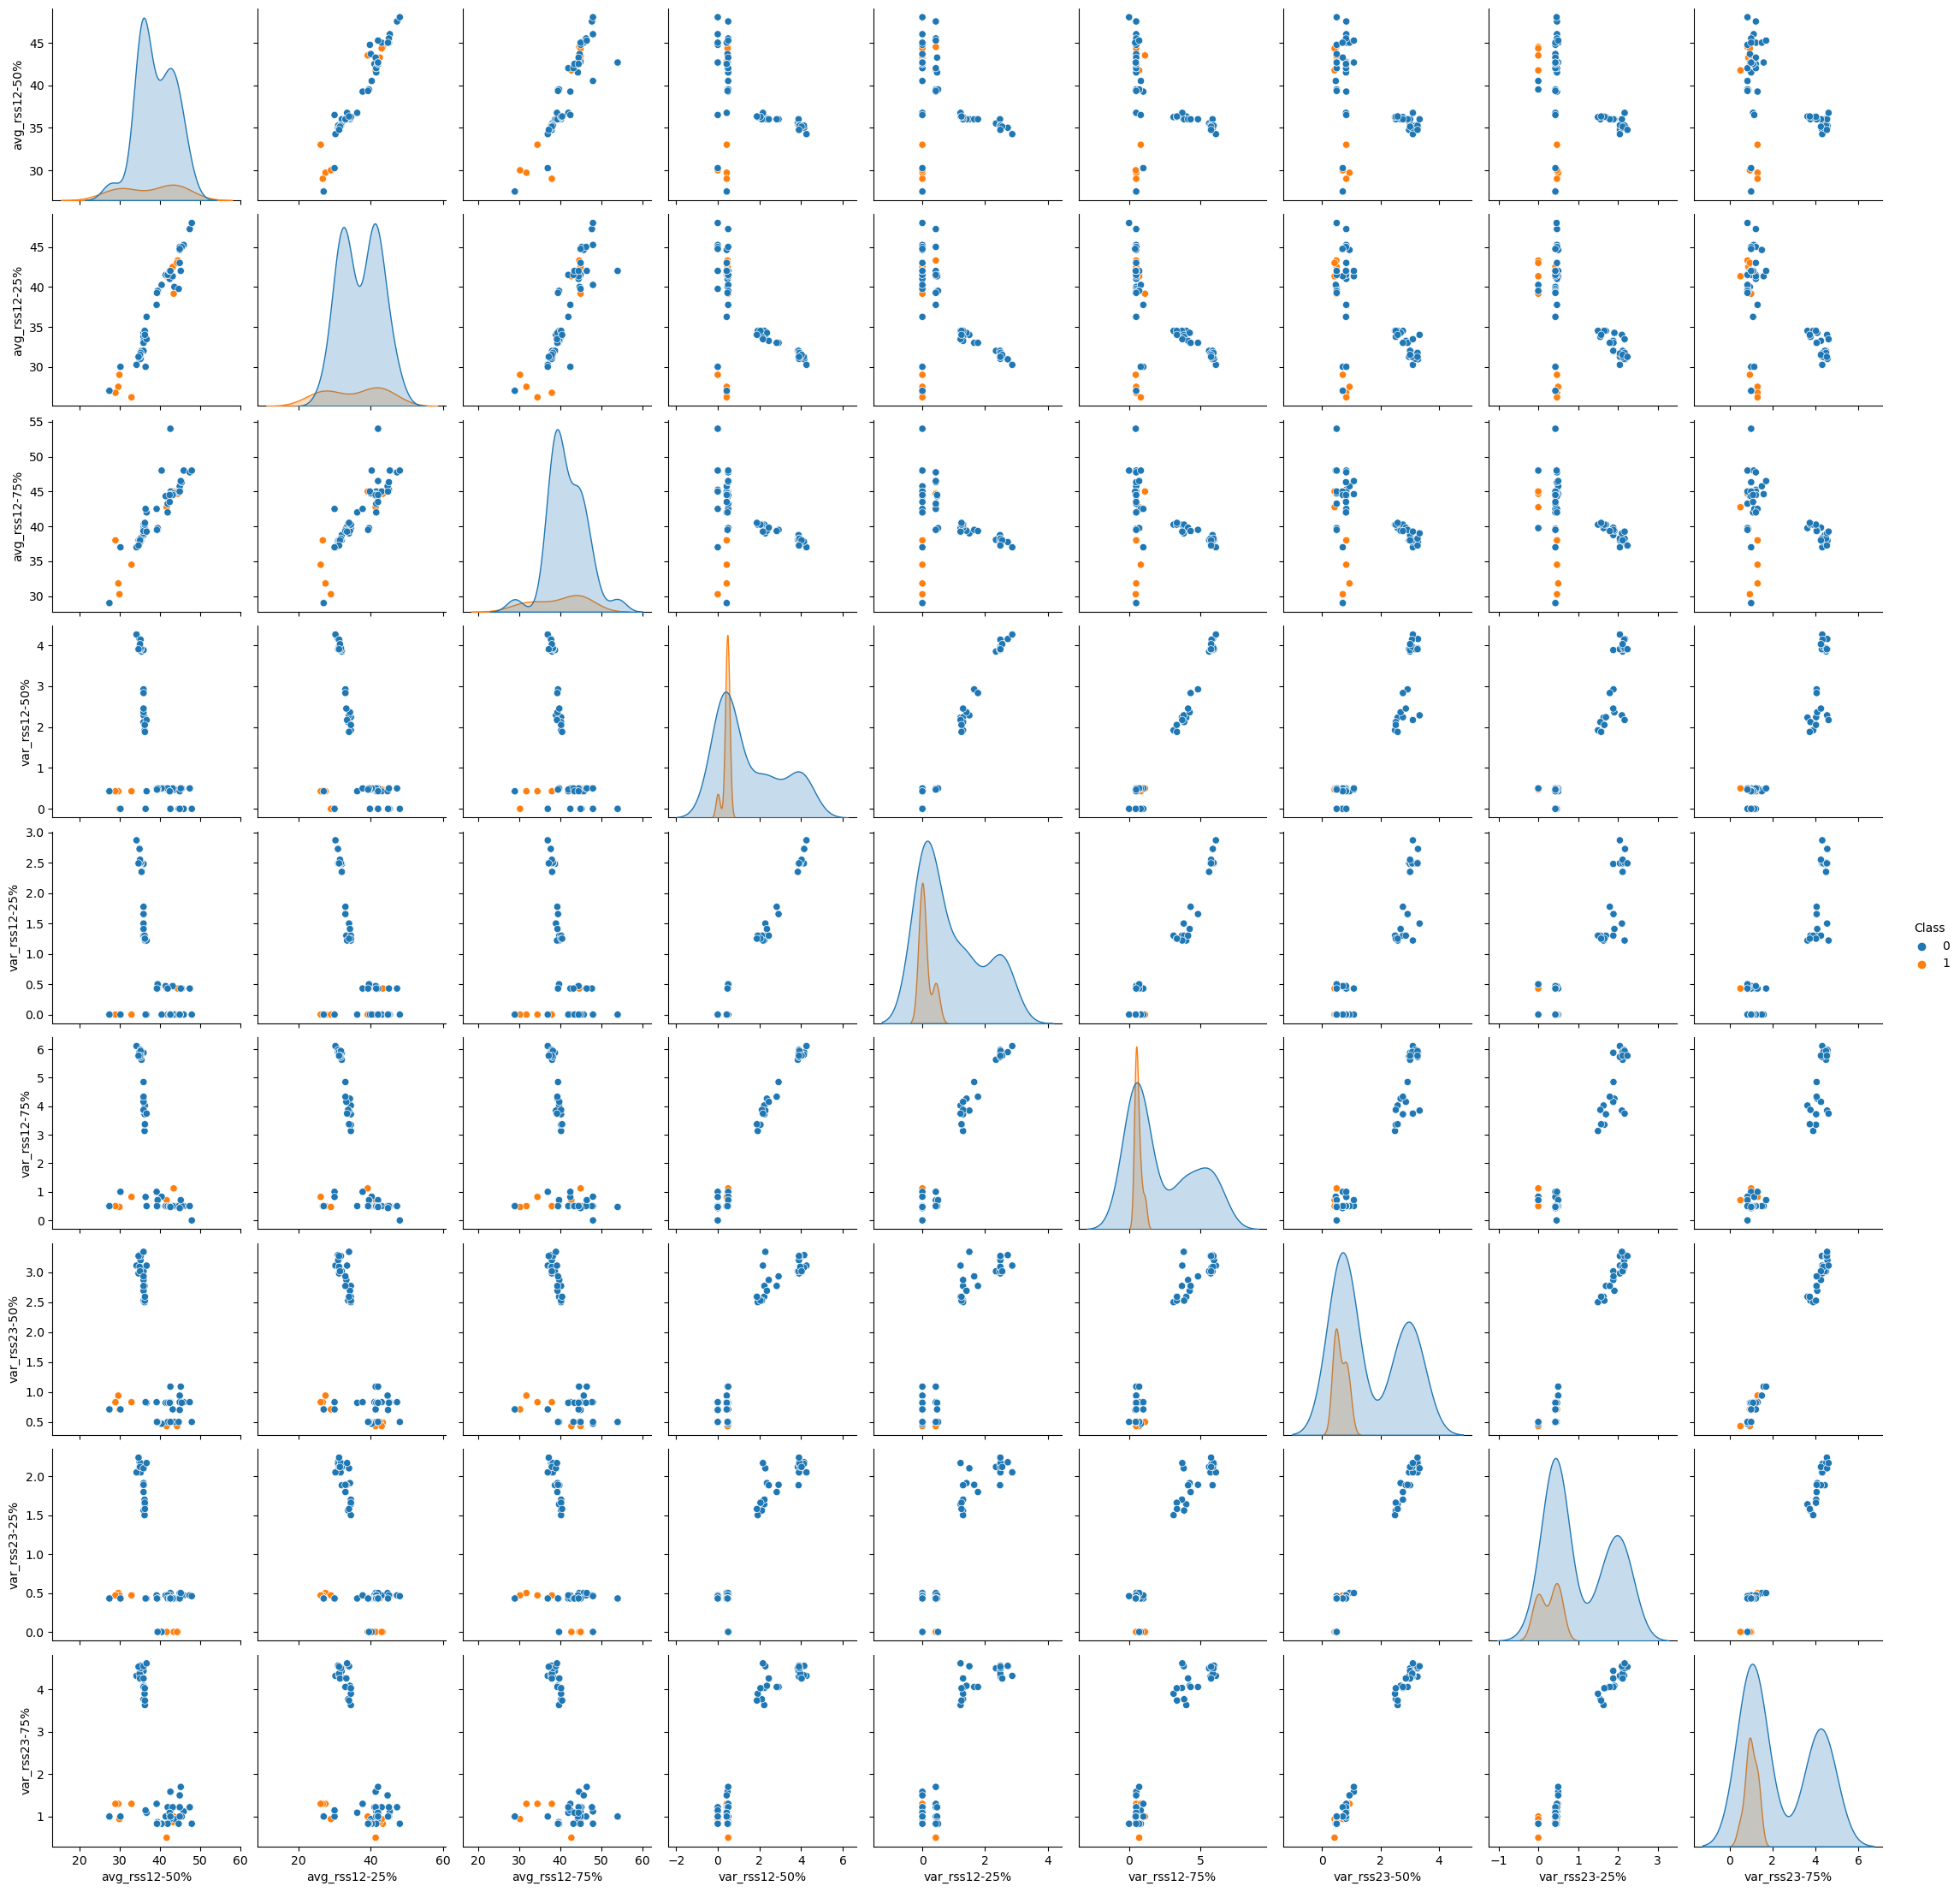

In [10]:
for ts in time_series_list:
    for head in headers:
        features.append(f"{ts}-{head}")
        
features.append('Class')
train_data_df = []
for key, value in train_data.items():
#     print(key)
    stats = value.describe()
#     print(stats)
    temp_list=[]
    for ts in time_series_list:
        for head in headers:
            temp_list.append(stats[ts][head])
    
    activity = key.split('/')[-2]
    if activity == 'bending1' or activity=='bending2':
        temp_list.append(1)
    else:
        temp_list.append(0)
        
    train_data_df.append(temp_list)

train_df = pd.DataFrame(train_data_df, columns=features)
train_df

#print(train_df[train_df['Class']==1])
sns.pairplot(data=train_df, hue='Class')

<font size=4>**(2aii) Break each time series in your training data set into ~2 equal equal lengths<br>
time series. Now instead of 6 time series, you have 12 ts for each training instance.<br>
Repeat 2a and do you see any considerable differences?** 

100%|██████████| 69/69 [00:00<00:00, 210.85it/s]


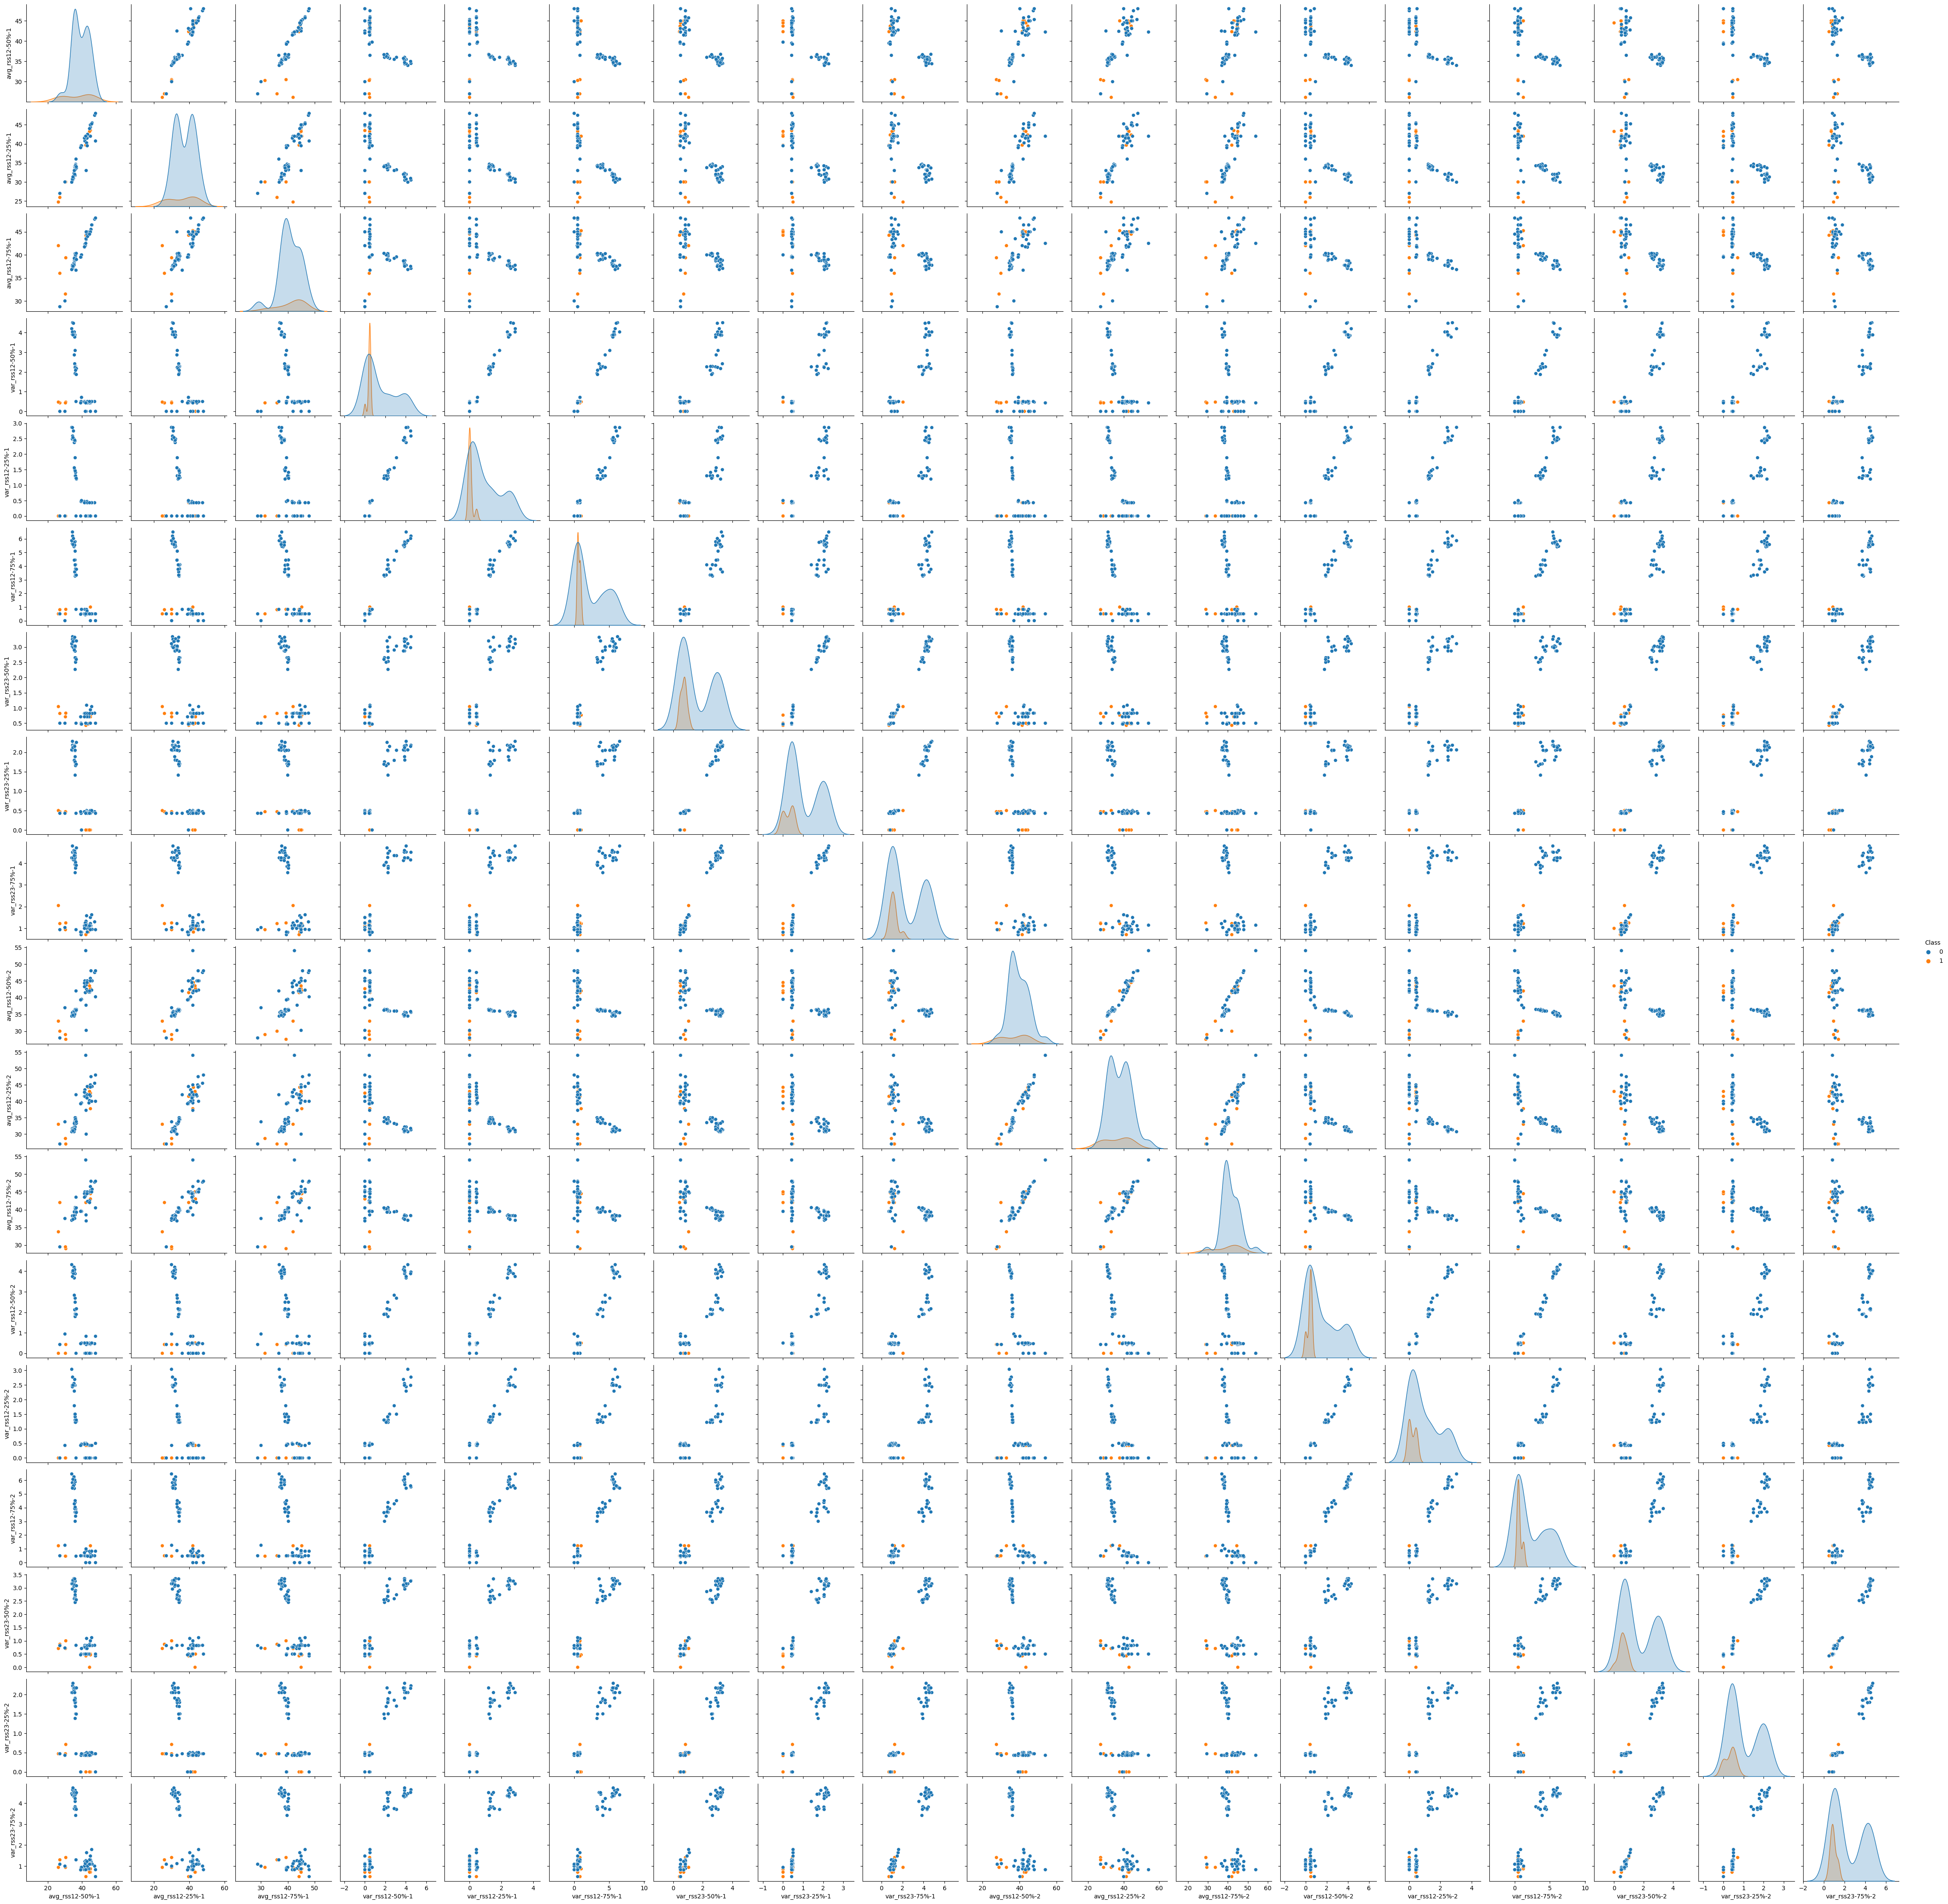

In [11]:
headers= ['50%', '25%', '75%'] # selected features
time_series_list = ['avg_rss12', 'var_rss12', 'var_rss23']
features = []

for idx in range(2):
    for ts in time_series_list:
        for head in headers:
            features.append(f"{ts}-{head}-{idx+1}")
        
features.append('Class')
# print(features)
idx = 0
train_data_df = []
for key, value in tqdm(train_data.items()):
    split_data = np.array_split(value, 2)
    # print(split_data)
    temp_list =[]
    for splt in split_data:
        idx +=1
        stats = splt.describe()
        for ts in time_series_list:
            for head in headers:
                temp_list.append(stats[ts][head])

    activity = key.split('/')[-2]
    if activity == 'bending1' or activity=='bending2':
        temp_list.append(1)
    else:
        temp_list.append(0)
        
    train_data_df.append(temp_list)

train_df = pd.DataFrame(train_data_df, columns=features)
train_df
sns.pairplot(data=train_df, hue='Class')

<font size=4>**- When comparing the resulting dataframes from part ai vs aii, the values are slightly different<br>
but the general trend of the scatterplots are very similar**

<font size=4>**(2aiii) Break each time seires in your training set into l = {1,2,..., 20} ts approx..<br>
and use logistic regression to solve the binary classification problem , using time-domain-feature.**

In [12]:
def build_features(time_series, headers, l):
    features = []
    for idx in range(l):
        for ts in time_series:
            for head in headers:
                features.append(f"{ts}-{head}-{idx+1}")

    features.append('Class')
    return features

def build_df(data, l, features, time_series, headers):
    train_data_df = []
    for key, value in data.items():
        split_data = np.array_split(value, l)
        # print(split_data)
        temp_list =[]
        for splt in split_data:
            # idx +=1
            stats = splt.describe()
            for ts in time_series:
                for head in headers:
                    temp_list.append(stats[ts][head])

        activity = key.split('/')[-2]
        if activity == 'bending1' or activity=='bending2':
            temp_list.append(1)
        else:
            temp_list.append(0)
            
        train_data_df.append(temp_list)
    
    train_df = pd.DataFrame(train_data_df, columns=features)
    return train_df

def logistic_regression(train_data, l, k_fold, headers, time_series):
    features = build_features(time_series,headers, l)
    # print(len(features), features)
    train_df = build_df(train_data, l, features, time_series, headers)
    # print(train_df)
    

    # split into x and y
    x_train = train_df.iloc[:,:-1]
    y_train = train_df['Class']
    
    skf = StratifiedKFold(k_fold, shuffle=True, random_state=1)
    model = LogisticRegression(penalty=None, solver='lbfgs')
    selector = RFECV(estimator=model, cv=skf, scoring='accuracy')
    selector.fit(X=x_train, y=y_train)
    
    return model, selector


In [13]:
headers= ['50%', '25%', '75%'] # selected features
time_series_list = ['avg_rss12', 'var_rss12', 'var_rss23']
time_series = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
features = []

k_fold_cv = 5
L_splits = 20

k_fold_cv_result = {'L':[], 'p-values':[], 'Train Score': [], 'Train Error': []}
lr_result = []
for l in tqdm(range(1, L_splits+1)):
    # run logistic regression
    # run rfecv
    model, selector = logistic_regression(train_data, l, k_fold_cv, headers, time_series)
    
    accuracy = selector.cv_results_['mean_test_score'].max()
    n_features = selector.n_features_
    k_fold_cv_result['L'].append(l)
    k_fold_cv_result['p-values'].append(n_features)
    k_fold_cv_result['Train Score'].append(accuracy)
    k_fold_cv_result['Train Error'].append(1-accuracy)

k_fold_df = pd.DataFrame(k_fold_cv_result)
k_fold_df
    

100%|██████████| 20/20 [01:29<00:00,  4.47s/it]


L  p-values  Train Score  Train Error
0    1         4     0.913187     0.086813
1    2        12     0.927473     0.072527
2    3         1     0.971429     0.028571
3    4         1     0.971429     0.028571
4    5         7     0.971429     0.028571
5    6         3     0.984615     0.015385
6    7         6     0.985714     0.014286
7    8        22     0.971429     0.028571
8    9        23     0.971429     0.028571
9   10        21     0.971429     0.028571
10  11         4     0.985714     0.014286
11  12         3     0.985714     0.014286
12  13         3     0.985714     0.014286
13  14         2     0.971429     0.028571
14  15        25     0.985714     0.014286
15  16         6     1.000000     0.000000
16  17        10     0.985714     0.014286
17  18         4     0.971429     0.028571
18  19         4     0.971429     0.028571
19  20         5     0.985714     0.014286

In [14]:
get_max_ts = k_fold_df['Train Score'].argmax()
best_l_split = k_fold_df['L'][get_max_ts]
p_val = k_fold_df['p-values'][get_max_ts]
print(f"Best value pair(l,p): ({best_l_split}, {p_val})")

Best value pair(l,p): (16, 6)


<font size=4>**(2aiv): Report the confusion matrix and show the ROC and AUC for your classifier on the train data.<br>
Report the parameters of your logistic_regression Bi's as well as p-values associated with them**

In [15]:
features = build_features(time_series, headers, best_l_split)
model, selector = logistic_regression(train_data, best_l_split, k_fold_cv, headers, time_series)

accuracy = selector.cv_results_['mean_test_score'].max()
n_features = selector.n_features_

select_features = []
for idx, feature in tqdm(enumerate(features[:-1])):
    if selector.support_[idx]:
        select_features.append(feature)

print(f"RFE selected features:\n{select_features}")
# print(select_features)


288it [00:00, 500812.42it/s]

RFE selected features:
['avg_rss23-25%-2', 'avg_rss23-25%-3', 'avg_rss23-50%-5', 'avg_rss23-25%-5', 'avg_rss12-75%-10', 'avg_rss12-75%-11']


In [16]:
train_data_df = build_df(train_data, best_l_split, features, time_series, headers)

x_train  = train_data_df.iloc[:,:-1]
y_train = train_data_df['Class']

rfe_select_df = x_train.loc[:, select_features]
# rfe_select_df

x_int = sm.add_constant(rfe_select_df)
model_ = sm.Logit(y_train, x_int)
# newton, default reached maximum iterations
model_summary = model_.fit(method='bfgs') 
model_summary.summary()

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        22:50:24   Log-Likelihood:            -5.5891e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1390   5697.143  -2.44e-05      1.000   -1.12e+04    1.12e+04
avg_rss23-25%-2      0.2552     95.753      0.003      0.998    -187.418     187.929
avg_rss23-25%-3      2.1995    117.237      0.019      0.985    -227.581     231.980
avg_rss23-50%-5      0.6459    337.903      0.002      0.998    -661.631     662.923
avg_rss23-25%-5      1.3349    304.952      0.004      0.997    -596.359     599.029
avg_rss12-75%-10    -1.4597    381.197     -0.004      0.997    -748.592     745.673
avg_rss12-75%-11    -0.7079    352.382     -0.002      0.998    -691.364     689.948
====================================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

In [17]:
# model_, x_train, y_train, select_features
x_select = x_train.loc[:, select_features]
model.fit(x_select, y_train.to_numpy(dtype=int))
y_pred = model.predict(x_select)

y_pred_probability = model.predict_proba(x_select)
y_true  = y_train.to_numpy(dtype=float)
y_pred = y_pred.round()
score = model.score(x_select, y_train.to_numpy())

Accuracy: 1.0
Confusion matrix: [[60  0]
 [ 0  9]]


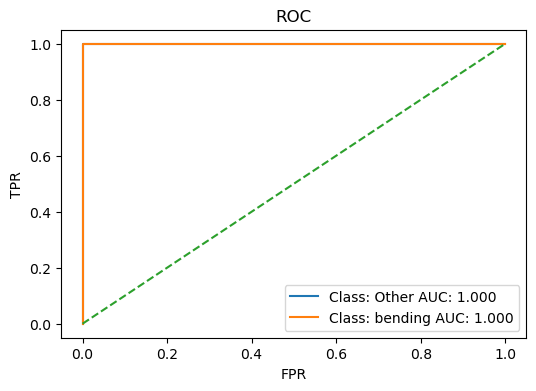

In [18]:
print(f"Accuracy: {score}")
print(f"Confusion matrix: {confusion_matrix(y_true, y_pred)}")

classes = {1: 'bending', 0:'Other'}
classes_rev= {'bending1': 0, 'bending2': 1, 'cycling': 2, 'lying': 3, 'sitting': 4, 'standing': 5, 'walking': 6}
all_classes = {0: 'bending1', 1: 'bending2', 2: 'cycling', 3: 'lying', 4: 'sitting', 5: 'standing', 6: 'walking'}
# plot roc
fig, axes = plt.subplots(figsize=(6,4))
axes.set_title("ROC")
for idx, cls in enumerate(model.classes_):
    y_pred = y_pred_probability[:,idx]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=cls)

    roc_auc = auc(fpr, tpr)
    
    axes.plot(fpr, tpr, label=f"Class: {classes[cls]} AUC: {roc_auc:.3f}")
    # else:
    #     axes.plot(fpr, tpr, label=f"Class: {all_classes[cls]}\tAUC: {roc_auc}")

axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

<font size=5>**(2av) Test your classifier on the test set. Remember to break the time<br>series
in your test set into the same number of time series into which you broke your training set.**

In [19]:
# use headers & time series list & best l split value (i.e l=16)
features = eatures = build_features(time_series, headers, best_l_split)
len(features)
test_classifier_df = build_df(test_data, best_l_split, features, time_series, headers)
# test_classifier_df
x_test = test_classifier_df.iloc[:,:-1]

y_test = test_classifier_df['Class']
y_test


0     1
1     1
2     0
3     0
4     0
5     1
6     1
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
Name: Class, dtype: int64

In [20]:
x_select = x_test.loc[:, select_features]
model.fit(x_select, y_test.to_numpy(dtype=int))
y_pred = model.predict(x_select)

y_pred_probability = model.predict_proba(x_select)
y_true  = y_test.to_numpy(dtype=float)
y_pred = y_pred.round()
score = model.score(x_select, y_test.to_numpy())

Accuracy: 1.0
Confusion matrix: [[15  0]
 [ 0  4]]


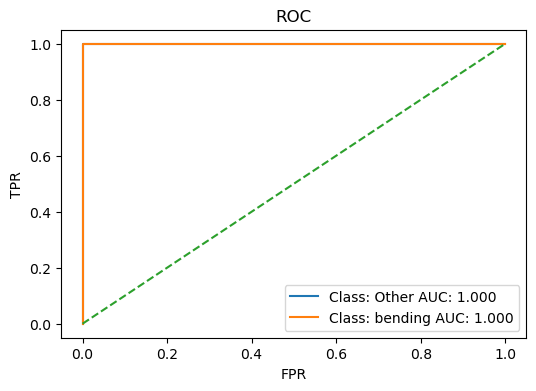

In [21]:
print(f"Accuracy: {score}")
print(f"Confusion matrix: {confusion_matrix(y_true, y_pred)}")

# plot roc
fig, axes = plt.subplots(figsize=(6,4))
axes.set_title("ROC")
for idx, cls in enumerate(model.classes_):
    y_pred = y_pred_probability[:,idx]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=cls)

    roc_auc = auc(fpr, tpr)
    
    axes.plot(fpr, tpr, label=f"Class: {classes[cls]} AUC: {roc_auc:.3f}")
    # else:
    #     axes.plot(fpr, tpr, label=f"Class: {all_classes[cls]}\tAUC: {roc_auc}")

axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

<font size=5>**- The accuracy obtained from running the classifier on the training set and test set were the same, 1.0**

<font size = 5>**(2avi) Do your classes semm to be well-represented to cause instability in calculating logistic regression parameters?<br>**
<font size=4>**- Considering the std error and p-values for my coefficients, there is complete separation, but the MLE method does not exist.<br>
The degree of separation can be inferred by looking at the magnitude of the coefficients.**

<font size = 5>**(2avii) From your confusion matrices you obtainedm do you see imbalanced classes?<br> if yes, build a logistic regression model  based on case-control sampling<br>
and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model<br>**
<font size=4>**- Considering the confusion matrix [[60, 0],[0,9]], 60 instances were predicted class 0, and 9 instances were predicted class 1.<br>
However, since the data contains significantly more class 0, than class 1, there is imbalances classes.**

In [22]:
# use headers list
k_fold_cv_result = {'L':[], 'p-values':[], 'Train Score': [], 'Train Error': []}
lr_result = []
for l in range(1, L_splits+1):
    features = build_features(time_series,headers, l)
    train_df = build_df(train_data, l, features, time_series, headers)
    # print(train_df)
    
    # handle imbalance
    class_0 = train_df.loc[train_df['Class'] == 0].shape[0]
    class_1 = train_df.loc[train_df['Class'] == 1].shape[0]

    min_class = min(class_0, class_1)
    max_class = max(class_0, class_1)
    if class_0 > class_1:
        minor_class = 1
        major_class = 0
    else:
        minor_class = 0
        major_class = 1

    minor_class_df = train_df.loc[train_df['Class'] == minor_class]
    major_class_df = train_df.loc[train_df['Class'] == major_class]

    minor_class_df = resample(minor_class_df, replace=True, random_state= 1, n_samples=max_class)
    train_df = pd.concat([major_class_df, minor_class_df])

    # split into x and y
    x_train = train_df.iloc[:,:-1]
    y_train = train_df['Class']
    
    skf = StratifiedKFold(k_fold_cv, shuffle=True, random_state=1)
    model = LogisticRegression(penalty=None, solver='lbfgs')
    selector = RFECV(estimator=model, cv=skf, scoring='accuracy')
    selector.fit(X=x_train, y=y_train)
    
    accuracy = selector.cv_results_['mean_test_score'].max()
    n_features = selector.n_features_
    k_fold_cv_result['L'].append(l)
    k_fold_cv_result['p-values'].append(n_features)
    k_fold_cv_result['Train Score'].append(accuracy)
    k_fold_cv_result['Train Error'].append(1-accuracy)

k_fold_df = pd.DataFrame(k_fold_cv_result)
k_fold_df

L  p-values  Train Score  Train Error
0    1         6     0.991667     0.008333
1    2         6     0.983333     0.016667
2    3         3     0.991667     0.008333
3    4         2     0.983333     0.016667
4    5         3     0.991667     0.008333
5    6         3     1.000000     0.000000
6    7         3     0.991667     0.008333
7    8         4     1.000000     0.000000
8    9         2     1.000000     0.000000
9   10        10     1.000000     0.000000
10  11         3     1.000000     0.000000
11  12         3     1.000000     0.000000
12  13         3     1.000000     0.000000
13  14         3     1.000000     0.000000
14  15         5     1.000000     0.000000
15  16         3     1.000000     0.000000
16  17         5     1.000000     0.000000
17  18         3     0.991667     0.008333
18  19        10     1.000000     0.000000
19  20         4     1.000000     0.000000

In [23]:
get_max_ts = k_fold_df['Train Score'].argmax()
best_l_split = k_fold_df['L'][get_max_ts]
p_val = k_fold_df['p-values'][get_max_ts]
print(f"Best value pair (l,p): ({best_l_split}, {p_val})")
train_accuracy = k_fold_df['Train Score'][get_max_ts]
print(f"Accuracy: {train_accuracy}")

Best value pair (l,p): (6, 3)
Accuracy: 1.0


In [24]:
features = build_features(time_series, headers, best_l_split)
model, selector = logistic_regression(train_data, best_l_split, k_fold_cv, headers, time_series)

accuracy = selector.cv_results_['mean_test_score'].max()
n_features = selector.n_features_

select_features = []
for idx, feature in tqdm(enumerate(features[:-1])):
    if selector.support_[idx]:
        select_features.append(feature)

print(f"RFE selected features:\n{select_features}")

108it [00:00, 2475326.95it/s]

RFE selected features:
['avg_rss23-75%-1', 'avg_rss23-25%-2', 'avg_rss12-75%-5']


In [25]:
features = build_features(time_series,headers, best_l_split)
train_df = build_df(train_data, best_l_split, features, time_series, headers)

# handle imbalance with best l
 # handle imbalance
class_0 = train_df.loc[train_df['Class'] == 0].shape[0]
class_1 = train_df.loc[train_df['Class'] == 1].shape[0]

min_class = min(class_0, class_1)
max_class = max(class_0, class_1)
if class_0 > class_1:
    minor_class = 1
    major_class = 0
else:
    minor_class = 0
    major_class = 1

minor_class_df = train_df.loc[train_df['Class'] == minor_class]
major_class_df = train_df.loc[train_df['Class'] == major_class]

minor_class_df = resample(minor_class_df, replace=True, random_state= 1, n_samples=max_class)
train_df = pd.concat([major_class_df, minor_class_df])

x_train = train_df.iloc[:,:-1]
y_train = train_df['Class']

In [26]:
def plot_roc(model, x_train, y_train, select_features, title):
    x_select = x_train.loc[:, select_features]
    model.fit(x_select, y_train.to_numpy(dtype=int))
    y_pred = model.predict(x_select)

    y_pred_probability = model.predict_proba(x_select)
    y_true  = y_train.to_numpy(dtype=float)
    y_pred = y_pred.round()
    score = model.score(x_select, y_train.to_numpy())

    print(f"Accuracy: {score}")
    print(f"Confusion matrix: {confusion_matrix(y_true, y_pred)}")

    # plot roc
    fig, axes = plt.subplots(figsize=(6,4))
    axes.set_title(title)
    for idx, cls in enumerate(model.classes_):
        y_pred = y_pred_probability[:,idx]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=cls)

        roc_auc = auc(fpr, tpr)
        
        axes.plot(fpr, tpr, label=f"Class: {classes[cls]} AUC: {roc_auc:.3f}")
        # else:
        #     axes.plot(fpr, tpr, label=f"Class: {all_classes[cls]}\tAUC: {roc_auc}")

    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("FPR")
    axes.set_ylabel("TPR")
    axes.legend()
    plt.show()

Accuracy: 1.0
Confusion matrix: [[60  0]
 [ 0 60]]


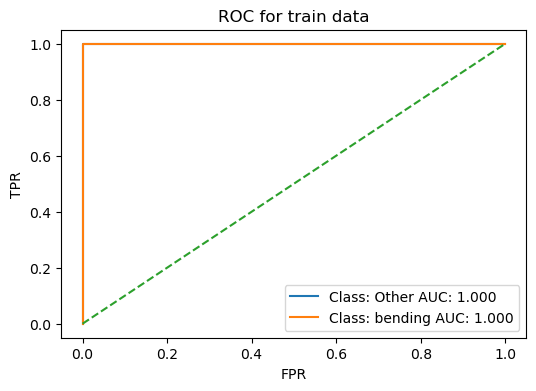

In [27]:
# plot roc for train data 
plot_roc(model, x_train, y_train, select_features, "ROC for train data")

Accuracy: 1.0
Confusion matrix: [[15  0]
 [ 0  4]]


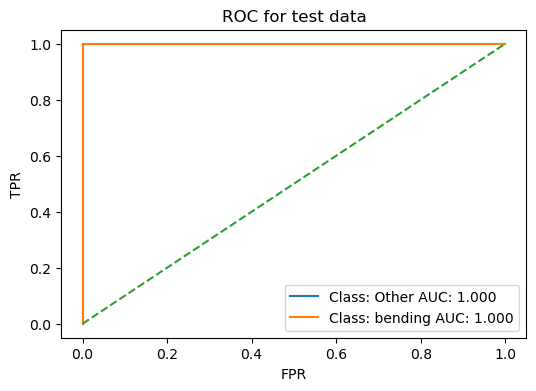

In [28]:
# plot roc for test data 
plot_roc(model, x_test, y_test, select_features, "ROC for test data")

<font size=5>**(1b) Binary classification using L1-penalized logistic regression**

<font size=5>**(1bi) Repeat 2aiii using L1-penalized logistic regression,instead of using p-values for variable selection, use L1 regularization**

In [29]:
def run_cv(train_data, test_data, l, time_series, headers, k_fold_cv, binary_class):
    features = build_features(time_series,headers, l)
    # print(len(features))
    test_df = build_df(test_data, l, features, time_series, headers)
    # print('hi')
    train_df = build_df(train_data, l, features, time_series, headers)
    x_train = train_df.iloc[:,:-1]
    y_train = train_df['Class']

    x_test = test_df.iloc[:,:-1]
    y_test = test_df['Class']

    if binary_class:
        model = LogisticRegressionCV(penalty='l1', max_iter=100, scoring='accuracy', cv=k_fold_cv,
                                     random_state=1, solver='liblinear')
        model.fit(x_train, y_train)
        idx = 0
        for i, c in enumerate(model.Cs_):
            if (c == model.C_[0]):
                idx = i

        train_score =  np.mean(model.scores_[1][:, idx])
        train_error = (1-train_score)
        
        return model, train_df, test_df, [l, train_score, train_error]    

In [30]:
headers= ['50%', '25%', '75%'] # selected features
time_series_list = ['avg_rss12', 'var_rss12', 'var_rss23']
time_series = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

k_fold_cv = 5
L_splits = 20
l1_penalized_result = []
accuracy = 0
best_l = 1
for l in tqdm(range(1,L_splits+1)):
    # print(l)
    model, train_df, test_df, result = run_cv(train_data, test_data, l, time_series, headers, k_fold_cv, True)
    l1_penalized_result.append(result)
    if result[1] > accuracy:
        accuracy = result[1]
        best_l = l

l1_penalized_df = pd.DataFrame(l1_penalized_result, columns=['L', 'train score', 'train error'])
l1_penalized_df

100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


L  train score  train error
0    1     0.928571     0.071429
1    2     0.928571     0.071429
2    3     0.942857     0.057143
3    4     0.942857     0.057143
4    5     0.957143     0.042857
5    6     0.942857     0.057143
6    7     0.942857     0.057143
7    8     0.942857     0.057143
8    9     0.957143     0.042857
9   10     0.942857     0.057143
10  11     0.957143     0.042857
11  12     0.971429     0.028571
12  13     0.971429     0.028571
13  14     0.957143     0.042857
14  15     0.957143     0.042857
15  16     0.942857     0.057143
16  17     0.942857     0.057143
17  18     0.957143     0.042857
18  19     0.971429     0.028571
19  20     0.971429     0.028571

In [31]:
# plot roc results
get_max_ts = l1_penalized_df['train score'].argmax()
best_l = l1_penalized_df['L'][get_max_ts]
print(f"Best L: {best_l}")
train_accuracy = l1_penalized_df['train score'][get_max_ts]
print(f"Accuracy: {train_accuracy:.5f}")

# confusion matrix
x_test = test_df.iloc[:,:-1]
y_test = test_df['Class']

x_train = train_df.iloc[:,:-1]
y_train = train_df['Class']

train_pred = model.predict_proba(x_train)
test_pred = model.predict_proba(x_test)

y_pred  = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

print(f"Confusion Matrix:\n{cm}")


Best L: 12
Accuracy: 0.97143
Confusion Matrix:
[[15  0]
 [ 1  3]]


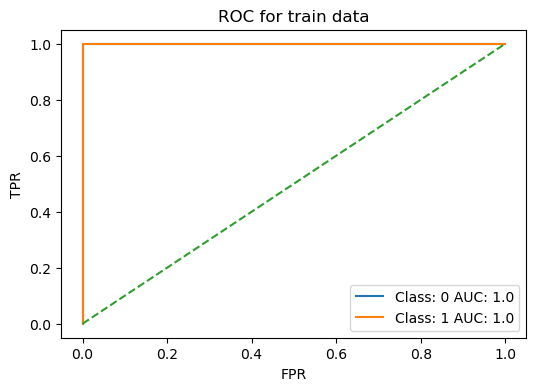

In [32]:
fig, axes = plt.subplots(figsize = (6, 4))
axes.set_title("ROC for train data")
for i, cls in enumerate(model.classes_):
    y_pred = train_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_train, y_pred, pos_label = cls)
    roc_auc = auc(fpr, tpr)
    if (len(model.classes_) == 2):
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
    else: 
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
                  
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

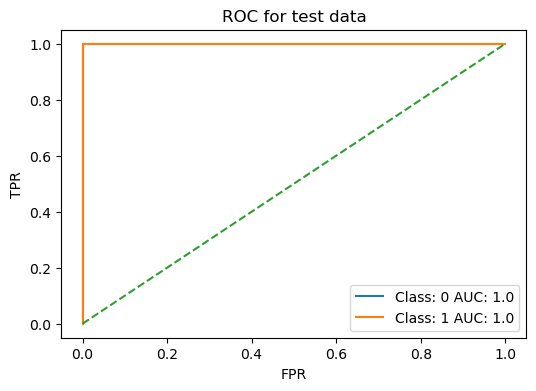

In [33]:
fig, axes = plt.subplots(figsize = (6, 4))
axes.set_title("ROC for test data")
for i, cls in enumerate(model.classes_):
    y_pred = test_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = cls)
    roc_auc = auc(fpr, tpr)
    if (len(model.classes_) == 2):
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
    else: 
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
                  
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

<font size=5>**(2bii) Compare the L1-penalized with variable selection using p-values.<br>
Which one performs better? Which one is easier to implement?**
<font size = 4>
- Based on my results, recursive feature elimination cross validation performs better than<br>
L1-penalized logistci regression, with an accuracy of 1.0 vs 0.97143.<br>
However, L1-penalized logistic regression is easier to implement because<br>you don't need to deal with feature selection.

<font size = 5>**(2c) Multi-class Classification (The Realistic Case)**

<font size=4>**(1ci) Find the best l in the same way as you found it in 2(b)i to build an<br>L1- penalized multinomial regression model to classify all activities in your training set. Report your test error.<br>Research how confusion matrices and ROC curves are defined for multiclass classification<br>and show them for this problem if possible.**

In [34]:
def get_class(key):
    activity = key.split('/')[-2]
    
    return classes_rev[activity]

def build_multi_df(data, l, features, time_series, headers):
    train_data_df = []
    for key, value in data.items():
        split_data = np.array_split(value, l)
        # print(split_data)
        temp_list =[]
        for splt in split_data:
            # idx +=1
            stats = splt.describe()
            for ts in time_series:
                for head in headers:
                    temp_list.append(stats[ts][head])

        temp_list.append(get_class(key))
        train_data_df.append(temp_list)
    
    train_df = pd.DataFrame(train_data_df, columns=features)
    return train_df

def run_multinomial(train_data, test_data, l, time_series, headers, k_fold_cv,):
    features = build_features(time_series,headers, l)
    # print(len(features))
    test_df = build_multi_df(test_data, l, features, time_series, headers)
    # print('hi')
    train_df = build_multi_df(train_data, l, features, time_series, headers)
    x_train = train_df.iloc[:,:-1]
    y_train = train_df['Class']

    x_test = test_df.iloc[:,:-1]
    y_test = test_df['Class']

    model = LogisticRegressionCV(penalty='l1', max_iter=6000, multi_class='multinomial', cv=k_fold_cv,
                                    random_state=1, solver='saga')
    model.fit(x_train, y_train)
    idx = 0
    for i, c in enumerate(model.Cs_):
        if (c == model.C_[0]):
            idx = i
    score = 0
    for cls in model.scores_.keys():
        score += np.mean(model.scores_[cls][:,idx])

    train_score = score/len(model.scores_.keys())
    train_error = (1-train_score)
    
    return model, train_df, test_df, [l, train_score, train_error]  

In [35]:
headers= ['50%', '25%', '75%'] # selected features
time_series_list = ['avg_rss12', 'var_rss12', 'var_rss23']
time_series = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

k_fold_cv = 5
L_splits = 20
l1_penalized_result = []
accuracy = 0
best_l = 1
for l in tqdm(range(1,L_splits+1)):
    # print(l)
    model, train_df, test_df, result = run_multinomial(train_data, test_data, l, time_series, headers, k_fold_cv)
    l1_penalized_result.append(result)
    if result[1] > accuracy:
        accuracy = result[1]
        best_l = l

l1_penalized_df = pd.DataFrame(l1_penalized_result, columns=['L', 'train score', 'train error'])
l1_penalized_df

100%|██████████| 20/20 [04:30<00:00, 13.52s/it]


L  train score  train error
0    1     0.900000     0.100000
1    2     0.797802     0.202198
2    3     0.768132     0.231868
3    4     0.783516     0.216484
4    5     0.769231     0.230769
5    6     0.770330     0.229670
6    7     0.769231     0.230769
7    8     0.739560     0.260440
8    9     0.740659     0.259341
9   10     0.739560     0.260440
10  11     0.709890     0.290110
11  12     0.695604     0.304396
12  13     0.695604     0.304396
13  14     0.695604     0.304396
14  15     0.724176     0.275824
15  16     0.724176     0.275824
16  17     0.681319     0.318681
17  18     0.695604     0.304396
18  19     0.709890     0.290110
19  20     0.710989     0.289011

In [36]:
print("L1-Penalized multinomial regression")
get_max_ts = l1_penalized_df['train score'].argmax()
best_l = l1_penalized_df['L'][get_max_ts]
print(f"Best L: {best_l}")
train_accuracy = l1_penalized_df['train score'][get_max_ts]
print(f"Accuracy: {train_accuracy:.5f}")

# confusion matrix
x_test = test_df.iloc[:,:-1]
y_test = test_df['Class']

x_train = train_df.iloc[:,:-1]
y_train = train_df['Class']

train_pred = model.predict_proba(x_train)
test_pred = model.predict_proba(x_test)

y_pred  = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

print(f"Confusion Matrix:\n{cm}")



L1-Penalized multinomial regression
Best L: 1
Accuracy: 0.90000
Confusion Matrix:
[[2 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


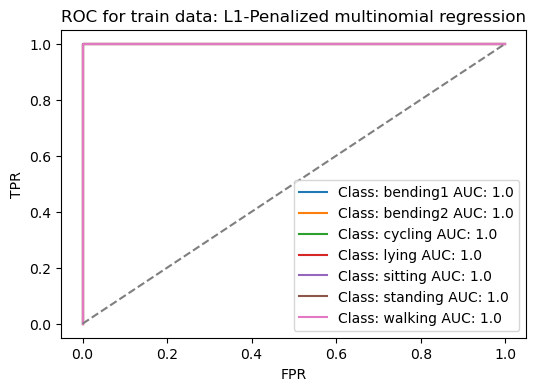

In [37]:
fig, axes = plt.subplots(figsize = (6, 4))
axes.set_title("ROC for train data: L1-Penalized multinomial regression")
for i, cls in enumerate(model.classes_):
    y_pred = train_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_train, y_pred, pos_label = cls)
    roc_auc = auc(fpr, tpr)
    if (len(model.classes_) == 2):
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
    else: 
        axes.plot(fpr, tpr, label = f"Class: {all_classes[cls]} AUC: {roc_auc}")
                  
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

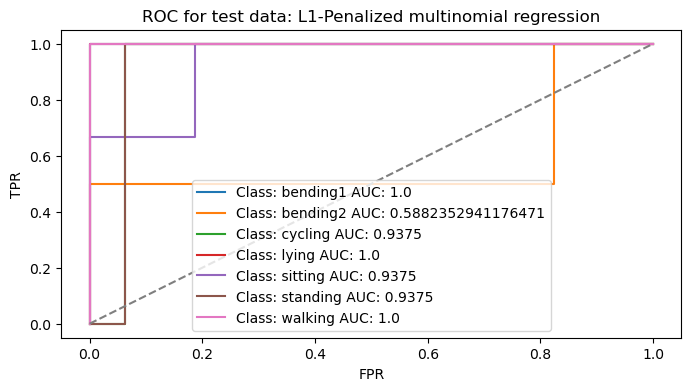

In [38]:
fig, axes = plt.subplots(figsize = (8, 4))
axes.set_title("ROC for test data: L1-Penalized multinomial regression")
for i, cls in enumerate(model.classes_):
    y_pred = test_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = cls)
    roc_auc = auc(fpr, tpr)
    if (len(model.classes_) == 2):
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
    else: 
        axes.plot(fpr, tpr, label = f"Class: {all_classes[cls]} AUC: {roc_auc}")
                  
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

<font size=5>**(2cii) Use Naive Bayes classifier (both gaussian and multinomial)**

In [39]:
def run_bayes(train_data, test_data, l, time_series, headers, k_fold_cv, mode):
    features = build_features(time_series,headers, l)

    test_df = build_multi_df(test_data, l, features, time_series, headers)
    train_df = build_multi_df(train_data, l, features, time_series, headers)
    x_train = train_df.iloc[:,:-1]
    y_train = train_df['Class']

    x_test = test_df.iloc[:,:-1]
    y_test = test_df['Class']
    if mode == 'gaussian':
        model = GaussianNB()

        score = cross_val_score(estimator=model, X=x_train, y = y_train, 
                                cv=StratifiedKFold(n_splits=k_fold_cv, random_state=1, shuffle=True),
                                scoring='accuracy')
        train_score = np.mean(score)

    else:
        model = MultinomialNB()
        score = cross_val_score(estimator=model, X=x_train, y = y_train, 
                                cv=StratifiedKFold(n_splits=k_fold_cv, random_state=1, shuffle=True),
                                scoring='accuracy')
        train_score = np.mean(score)
    train_error = (1-train_score)
    
    return model, train_df, test_df, [l, train_score, train_error]  

In [40]:
headers= ['50%', '25%', '75%'] # selected features
time_series_list = ['avg_rss12', 'var_rss12', 'var_rss23']
time_series = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

k_fold_cv = 5
L_splits = 20
gaussian_result = []
accuracy = 0
best_l = 1
for l in tqdm(range(1,L_splits+1)):
    # print(l)
    model, train_df, test_df, result = run_bayes(train_data, test_data, l, time_series, headers, k_fold_cv, 'gaussian')
    gaussian_result.append(result)
    if result[1] > accuracy:
        accuracy = result[1]
        best_l = l

gaussian_df = pd.DataFrame(l1_penalized_result, columns=['L', 'train score', 'train error'])
gaussian_df

100%|██████████| 20/20 [00:42<00:00,  2.10s/it]


L  train score  train error
0    1     0.900000     0.100000
1    2     0.797802     0.202198
2    3     0.768132     0.231868
3    4     0.783516     0.216484
4    5     0.769231     0.230769
5    6     0.770330     0.229670
6    7     0.769231     0.230769
7    8     0.739560     0.260440
8    9     0.740659     0.259341
9   10     0.739560     0.260440
10  11     0.709890     0.290110
11  12     0.695604     0.304396
12  13     0.695604     0.304396
13  14     0.695604     0.304396
14  15     0.724176     0.275824
15  16     0.724176     0.275824
16  17     0.681319     0.318681
17  18     0.695604     0.304396
18  19     0.709890     0.290110
19  20     0.710989     0.289011

In [41]:
model.fit(x_train, y_train)

print("Naive Bayes' classifier using Gaussian")
get_max_ts = l1_penalized_df['train score'].argmax()
best_l = l1_penalized_df['L'][get_max_ts]
print(f"Best L: {best_l}")
train_accuracy = l1_penalized_df['train score'][get_max_ts]
print(f"Accuracy: {train_accuracy:.5f}")

# confusion matrix
x_test = test_df.iloc[:,:-1]
y_test = test_df['Class']

x_train = train_df.iloc[:,:-1]
y_train = train_df['Class']

train_pred = model.predict_proba(x_train)
test_pred = model.predict_proba(x_test)

y_pred  = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

print(f"Confusion Matrix:\n{cm}")

Naive Bayes' classifier using Gaussian
Best L: 1
Accuracy: 0.90000
Confusion Matrix:
[[2 0 0 0 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


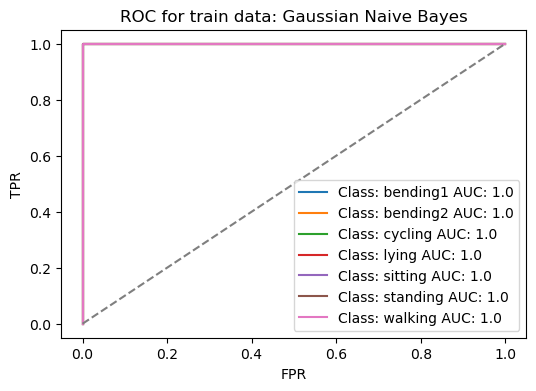

In [42]:
# plot gaussion naive bayes
fig, axes = plt.subplots(figsize = (6, 4))
axes.set_title("ROC for train data: Gaussian Naive Bayes")
for i, cls in enumerate(model.classes_):
    y_pred = train_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_train, y_pred, pos_label = cls)
    roc_auc = auc(fpr, tpr)
    if (len(model.classes_) == 2):
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
    else: 
        axes.plot(fpr, tpr, label = f"Class: {all_classes[cls]} AUC: {roc_auc}")
                  
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

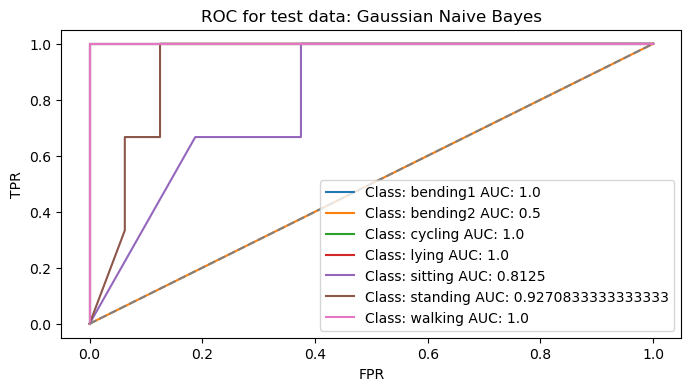

In [43]:
fig, axes = plt.subplots(figsize = (8, 4))
axes.set_title("ROC for test data: Gaussian Naive Bayes")
for i, cls in enumerate(model.classes_):
    y_pred = test_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = cls)
    roc_auc = auc(fpr, tpr)
    if (len(model.classes_) == 2):
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
    else: 
        axes.plot(fpr, tpr, label = f"Class: {all_classes[cls]} AUC: {roc_auc}")
                  
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

In [44]:
multi_priors_result = []
for l in tqdm(range(1,L_splits+1)):
    # print(l)
    model, train_df, test_df, result = run_bayes(train_data, test_data, l, time_series, headers, k_fold_cv, 'priors')
    multi_priors_result.append(result)
    if result[1] > accuracy:
        accuracy = result[1]
        best_l = l

multi_priors_df = pd.DataFrame(l1_penalized_result, columns=['L', 'train score', 'train error'])
multi_priors_df

100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


L  train score  train error
0    1     0.900000     0.100000
1    2     0.797802     0.202198
2    3     0.768132     0.231868
3    4     0.783516     0.216484
4    5     0.769231     0.230769
5    6     0.770330     0.229670
6    7     0.769231     0.230769
7    8     0.739560     0.260440
8    9     0.740659     0.259341
9   10     0.739560     0.260440
10  11     0.709890     0.290110
11  12     0.695604     0.304396
12  13     0.695604     0.304396
13  14     0.695604     0.304396
14  15     0.724176     0.275824
15  16     0.724176     0.275824
16  17     0.681319     0.318681
17  18     0.695604     0.304396
18  19     0.709890     0.290110
19  20     0.710989     0.289011

In [45]:
model.fit(x_train, y_train)

print("Naive Bayes' classifier using Multinomial Priors")
get_max_ts = l1_penalized_df['train score'].argmax()
best_l = l1_penalized_df['L'][get_max_ts]
print(f"Best L: {best_l}")
train_accuracy = l1_penalized_df['train score'][get_max_ts]
print(f"Accuracy: {train_accuracy:.5f}")

# confusion matrix
x_test = test_df.iloc[:,:-1]
y_test = test_df['Class']

x_train = train_df.iloc[:,:-1]
y_train = train_df['Class']

train_pred = model.predict_proba(x_train)
test_pred = model.predict_proba(x_test)

y_pred  = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

print(f"Confusion Matrix:\n{cm}")

Naive Bayes' classifier using Multinomial Priors
Best L: 1
Accuracy: 0.90000
Confusion Matrix:
[[2 0 0 0 0 0 0]
 [2 0 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


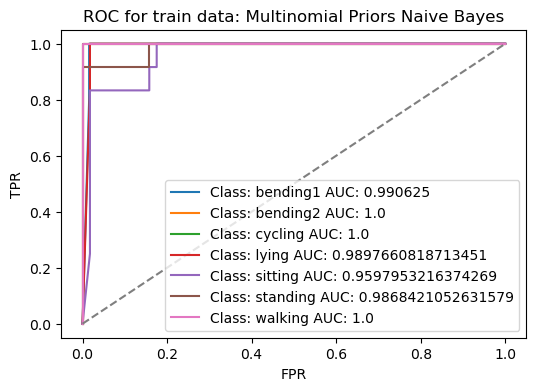

In [46]:
# plot gaussion naive bayes
fig, axes = plt.subplots(figsize = (6, 4))
axes.set_title("ROC for train data: Multinomial Priors Naive Bayes")
for i, cls in enumerate(model.classes_):
    y_pred = train_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_train, y_pred, pos_label = cls)
    roc_auc = auc(fpr, tpr)
    if (len(model.classes_) == 2):
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
    else: 
        axes.plot(fpr, tpr, label = f"Class: {all_classes[cls]} AUC: {roc_auc}")
                  
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

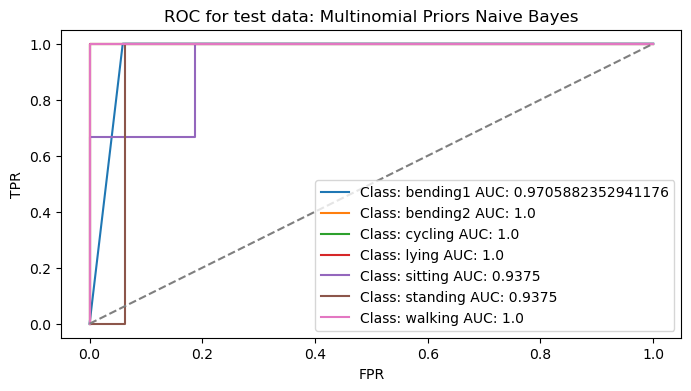

In [47]:
fig, axes = plt.subplots(figsize = (8, 4))
axes.set_title("ROC for test data: Multinomial Priors Naive Bayes")
for i, cls in enumerate(model.classes_):
    y_pred = test_pred[:, i]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = cls)
    roc_auc = auc(fpr, tpr)
    if (len(model.classes_) == 2):
        axes.plot(fpr, tpr, label = f"Class: {cls} AUC: {roc_auc}")
    else: 
        axes.plot(fpr, tpr, label = f"Class: {all_classes[cls]} AUC: {roc_auc}")
                  
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.legend()
plt.show()

<font size =5>**(2ciii) Which method is better for multiclass classification?**
- The accuracy for both guassian and multinomial produced was the same, 0.90.<br>
However, when looking at the ROC plots, multinomial priors seems to perform better on<br>the test data
than guassian does, although the train ROC plots look better for gaussian.